In [1]:
import pandas as pd
import numpy as np
import sklearn.metrics as metrics
from sklearn.impute import KNNImputer, MissingIndicator
from sklearn.preprocessing import LabelEncoder, StandardScaler, QuantileTransformer, MinMaxScaler, Normalizer
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer, KElbowVisualizer, silhouette_visualizer
import warnings
import seaborn as sns
import matplotlib.pyplot as plot
import matplotlib.cm as cm
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.datasets import mnist
sns.set_palette('husl')
sns.set()
from ipywidgets import interact, IntSlider, FloatSlider, fixed
warnings.filterwarnings('ignore')
import pathlib
import os

#### Load raw Data

In [3]:
data = pd.read_csv("water.csv", header=None)

In [4]:
data.shape

(1001, 2251)

#### Check if there are any missing data and the percentage of the missing values in each column in the given dataset. 

In [5]:
print("Missing values")
print(data.isnull().sum()*100/len(data))
print("\n")
print("Missing values")
data.isna().sum()*100/len(data)

Missing values
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
2246    0.0
2247    0.0
2248    0.0
2249    0.0
2250    0.0
Length: 2251, dtype: float64


Missing values


0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
2246    0.0
2247    0.0
2248    0.0
2249    0.0
2250    0.0
Length: 2251, dtype: float64

- Set the 2251st column as Flag and drop from the data frame

In [6]:
flag = data.iloc[:,2250]

In [7]:
data = data.drop(columns=[2250])

-  Reshape the feature vector of dim 2250 into a 750 X 3

In [9]:
# Convert the dataframe into an array for easy reshaping
X = data.to_numpy()
X = X.reshape((1001, 750, 3))

- take the first vector and subtract it from all the vectors in the snapshot. 

In [10]:
X_new = np.zeros((X.shape[0], X.shape[1], X.shape[2]))
y_new = np.zeros((X.shape[0], X.shape[1], 1))

# loop through all 1001 slices  in the 3d matrix
for i in range(0, len(X)):
    # Subtract coordinates in row 0 from coordinates in all other rows
    X_new[i, :, :] = X[i][:, :] - X[i][0, :]
    y_new[i, :, 0] = flag[i]

- reshape the feature vector back to vector of dim 2250

In [11]:
X = X_new.reshape((1001, 2250))

##### Dimensionality Reduction
- Note that we have a ridiculously high dimensionality of 2250 feature vectors, so it is only expected to use PCA to reduce this dimensionality.
- The reason for this choice is because PCA supports unsupervised learning.
- The feature space has an extremely high dimensionality of 2250 feature vectors. One can therefore intuitively note that obtaining distance measures at such high dimensions is notoriously difficult.  
- One approach to evaluating the performance of PCA is to examine the percentage of the total variance that is accounted for by each principal component. The total variance of the data is equal to the sum of the variances of all the features. 
- The variance of each principal component is equivalent to the eigenvalue of the corresponding eigenvector. By dividing each eigenvalue by the sum of all the eigenvalues, we can determine the percentage of the total variance that is captured by each principal component.
- So to find out if the reduced set of feature vectors can capture ~ 100% of the overall data structute, we will call the Decomposition.PCA() method and use the total variance ratio as a function of number of components. 
- this automatically sorts the components in order of increasing variance, therefore the first n-components that results in ~100% of the total variance ratio will be reserved as the set of new feature vectors

Text(0, 0.5, 'total explained variance')

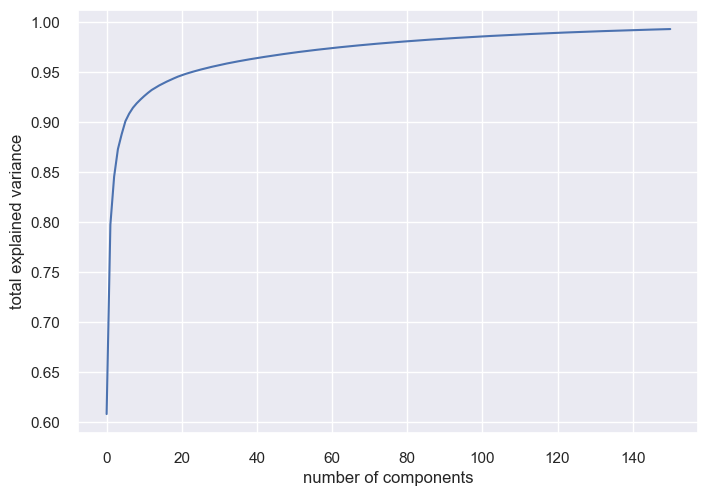

In [12]:
pca = PCA().fit(X)
plot.plot(np.cumsum(pca.explained_variance_ratio_)[0:151])
plot.xlabel('number of components')
plot.ylabel('total explained variance')

- The above curve shows how much of the total, 2250-dimensional variance is contained within the first N components. 
- We see that a 150-dimensional projection retains a lot of information as measured by the explained variance and that we’d need about 150 components to retain ~100% of the variance.

- So while the size of the reduced feature space is remarkably smaller than the size of the raw feature space, it is still achieving ~100% explained variance. 

In [13]:
pca = PCA(n_components=150)
X_reduced = pca.fit_transform(X) 
print(X_reduced.shape)

(1001, 150)


#### Kmeans clustering algorithm

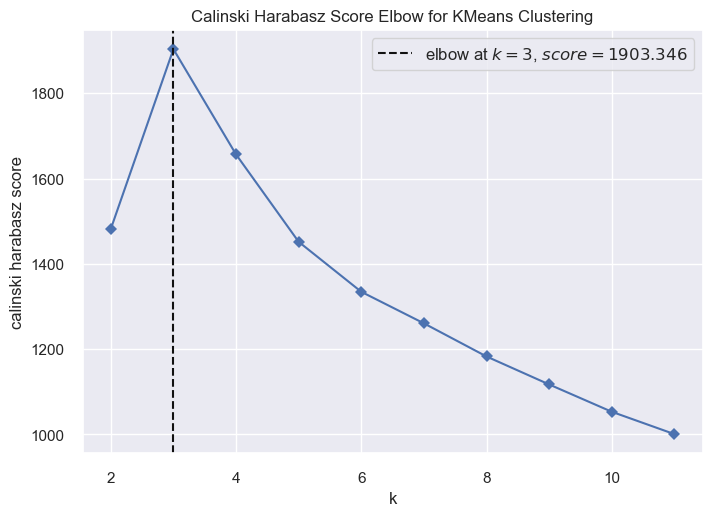

<Axes: title={'center': 'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [14]:
kmeans_model = KMeans()
n_clusters_range = (2, 12)
visualizer = KElbowVisualizer(kmeans_model, k=n_clusters_range, metric='calinski_harabasz', timings=False, locate_elbow=True)
visualizer.fit(X_reduced)
visualizer.show()

#### Comments

- Choice of metric: The Calinski-Harabasz index (also known as the Variance Ratio Criterion) is a metric used to evaluate the quality of clustering. It calculates the ratio of the between-cluster dispersion to within-cluster dispersion for a given solution with k clusters.

- Higher values of the CH index indicate better clustering results. Note that if the CH index is high, it means that the clusters are well-separated and distinct from each other, making it easier to distinguish between them. If the CH index is low, it suggests that the clusters are not well-separated and may overlap, or that the data does not separate well into distinct clusters. 

- From the plot above, we can see that the high CH index predicted is for n_cluster = 3

Text(0.04, 0.5, 'Number of Clusters')

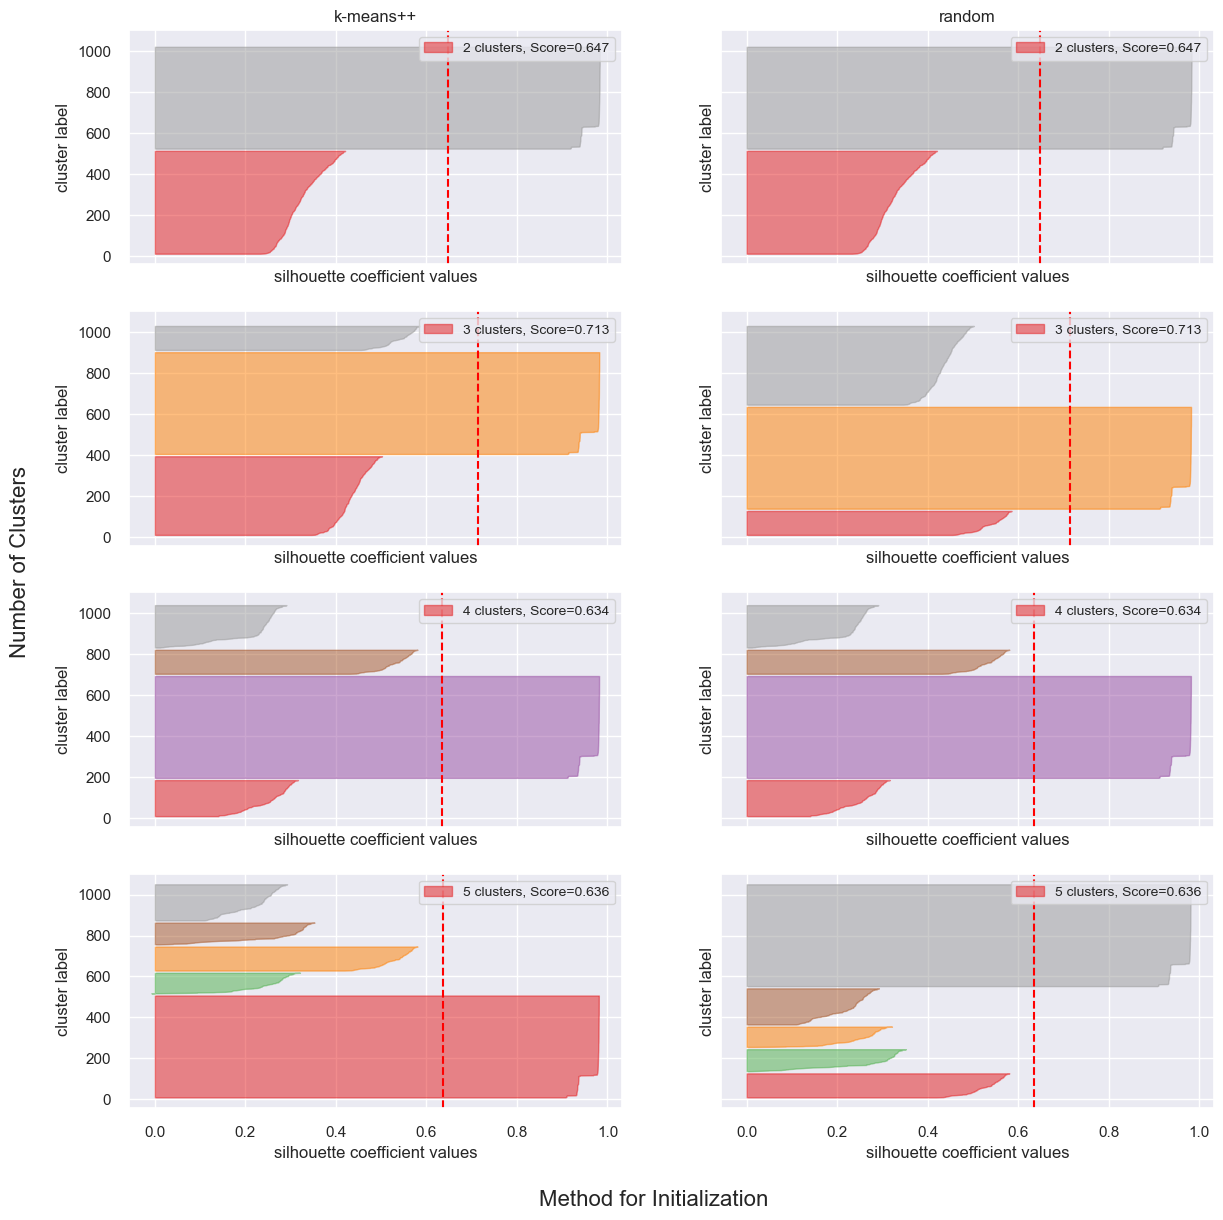

In [15]:
#initialize number of clusters as a list for looping
n_clusters = list(np.arange(2, 6))

#list for methods of initialization to be considered 
init_method = ["k-means++", "random"]

# dataframe for errors for init_method, n_cluster combinations
kmeans_error = pd.DataFrame(columns=["k-means++", "random"], index=n_clusters, dtype=float)

# save labels to 3d array for  init_method, n_cluster combinations
y_kmeans_pr = np.zeros((len(n_clusters), X_reduced.shape[0], len(init_method)))

fig, axs = plot.subplots(nrows=len(n_clusters), ncols=len(init_method), figsize=(14, 14), sharex=True, sharey=True)

for n_idx, n in enumerate(n_clusters):
    for method_idx, method in enumerate(init_method):
        kmeans = KMeans(n_clusters=n, init=method)
        kmeans.fit(X_reduced)
        y_kmeans = kmeans.predict(X_reduced)
        y_kmeans_pr[n_idx, :, method_idx] = y_kmeans
        kmeans_error.loc[n, method] = kmeans.inertia_
        # Creating SilhouetteVisualizer and assigning it to an axis
        visualizer = SilhouetteVisualizer(kmeans, ax=axs[n_idx, method_idx], is_fitted='auto', legend=True)
        visualizer.fit(X_reduced)
        # Setting subplot legends via axis
        axs[n_idx, method_idx].legend([f'{n} clusters, Score={visualizer.silhouette_score_:.3f}'],
                                            loc="upper right", frameon=True, fontsize=10)
        # Setting subplot x and y labels
        axs[n_idx, method_idx].set(xlabel='silhouette coefficient values', ylabel='cluster label')

axs[0, 0].set_title("k-means++")
axs[0, 1].set_title("random")

fig.text(0.5, 0.04, 'Method for Initialization', ha='center', fontsize=16)
fig.text(0.04, 0.5, 'Number of Clusters', va='center', rotation='vertical',fontsize=16)

#### Comments

- Reason for methods of initialization chosen: Random Initialization is the most basic initialization method and it involves selecting K random points from the data as the initial centroids. Although simple, it can sometimes lead to suboptimal results. K-means++ Initialization aims to improve the clustering results obtained with random initialization. 
- However, it is seen from the plot that the highest silhoutte value is n_cluster 3 with 0.713 since silhouette score ranges from -1 to 1, where higher values indicate better clustering of data. 

In [16]:
kmeans = KMeans(n_clusters=3, init="k-means++")
kmeans.fit(X_reduced)
y_kmeans = kmeans.predict(X_reduced)

#### Comments
- It appears that the best cluster to train this model is n_cluster = 3.
- This clustering algorithm doesn't produce a good fit seeing as there is a wide flunctuation in the size of the silhoutte plots and there are clusters with below average silhoutte scores.
- I suspect the reason for the poor performance is the algorithm's inflexibility regarding cluster shape and its sensitivity to the "curse of dimensionality" often arising from this high-dimensional dataset i.e. as the number of dimensions increases, the distance between the data points grows proportionally, making it difficult to identify any meaningful patterns or clusters in the data.

#### Agglomerative Clustering algorithm

-  This algorithm merges clusters together based on a certain linkage distance, which means that clusters that are closer together in distance get merged first. This merging happens recursively until all clusters are combined into a single one. 

- This might help with the cluster formations that resemble spheres since it is able to detect clusters of arbitary shapes and doesn't make assumptions about how the data is arranged or require the number of clusters to be pre-defined, and instead determines the proximity of different points itself.

### To visualize the silhoutte metric for cluster evaluation, I implemented the following code from the yellowbrick documentation. 
## PLEASE RUN FIRST

In [17]:
# yellowbrick.cluster.silhouette
# Implements visualizers using the silhouette metric for cluster evaluation.
#
# Author:   Benjamin Bengfort
# Author:   Rebecca Bilbro
# Created:  Mon Mar 27 10:09:24 2017 -0400
#
# Copyright (C) 2017 The scikit-yb developers
# For license information, see LICENSE.txt
#
# ID: silhouette.py [57b563b] benjamin@bengfort.com $

"""
Implements visualizers that use the silhouette metric for cluster evaluation.
"""

##########################################################################
## Imports
##########################################################################

import numpy as np
import matplotlib.ticker as ticker

from sklearn.metrics import silhouette_score, silhouette_samples

from yellowbrick.utils import check_fitted
from yellowbrick.style import resolve_colors
from yellowbrick.cluster.base import ClusteringScoreVisualizer


##########################################################################
## Silhouette Method for K Selection
##########################################################################


class agc_SilhouetteVisualizer(ClusteringScoreVisualizer):
    """
    The Silhouette Visualizer displays the silhouette coefficient for each
    sample on a per-cluster basis, visually evaluating the density and
    separation between clusters. The score is calculated by averaging the
    silhouette coefficient for each sample, computed as the difference
    between the average intra-cluster distance and the mean nearest-cluster
    distance for each sample, normalized by the maximum value. This produces a
    score between -1 and +1, where scores near +1 indicate high separation
    and scores near -1 indicate that the samples may have been assigned to
    the wrong cluster.

    In SilhouetteVisualizer plots, clusters with higher scores have wider
    silhouettes, but clusters that are less cohesive will fall short of the
    average score across all clusters, which is plotted as a vertical dotted
    red line.

    This is particularly useful for determining cluster imbalance, or for
    selecting a value for K by comparing multiple visualizers.

    Parameters
    ----------
    estimator : a Scikit-Learn clusterer
        Should be an instance of a centroidal clustering algorithm (``KMeans``
        or ``MiniBatchKMeans``). If the estimator is not fitted, it is fit when
        the visualizer is fitted, unless otherwise specified by ``is_fitted``.

    ax : matplotlib Axes, default: None
        The axes to plot the figure on. If None is passed in the current axes
        will be used (or generated if required).

    colors : iterable or string, default: None
        A collection of colors to use for each cluster group. If there are
        fewer colors than cluster groups, colors will repeat. May also be a
        Yellowbrick or matplotlib colormap string.

    is_fitted : bool or str, default='auto'
        Specify if the wrapped estimator is already fitted. If False, the
        estimator will be fit when the visualizer is fit, otherwise, the
        estimator will not be modified. If 'auto' (default), a helper method
        will check if the estimator is fitted before fitting it again.

    kwargs : dict
        Keyword arguments that are passed to the base class and may influence
        the visualization as defined in other Visualizers.

    Attributes
    ----------
    silhouette_score_ : float
        Mean Silhouette Coefficient for all samples. Computed via scikit-learn
        `sklearn.metrics.silhouette_score`.

    silhouette_samples_ : array, shape = [n_samples]
        Silhouette Coefficient for each samples. Computed via scikit-learn
        `sklearn.metrics.silhouette_samples`.

    n_samples_ : integer
        Number of total samples in the dataset (X.shape[0])

    n_clusters_ : integer
        Number of clusters (e.g. n_clusters or k value) passed to internal
        scikit-learn model.

    y_tick_pos_ : array of shape (n_clusters,)
        The computed center positions of each cluster on the y-axis

    Examples
    --------

    >>> from yellowbrick.cluster import agc_SilhouetteVisualizer
    >>> from sklearn.cluster import KMeans
    >>> model = agc_SilhouetteVisualizer(KMeans(10))
    >>> model.fit(X)
    >>> model.show()
    """

    def __init__(self, estimator, ax=None, colors=None, is_fitted="auto", **kwargs):

        # Initialize the visualizer bases
        super(agc_SilhouetteVisualizer, self).__init__(estimator, ax=ax, **kwargs)

        # Visual Properties
        # Use colors if it is given, otherwise attempt to use colormap which
        # which will override colors. If neither is found, default to None.
        # The colormap may yet still be found in resolve_colors
        self.colors = colors
        if "colormap" in kwargs:
            self.colors = kwargs["colormap"]

    def fit(self, X, y=None, **kwargs):
        """
        Fits the model and generates the silhouette visualization.
        """
        # TODO: decide to use this method or the score method to draw.
        # NOTE: Probably this would be better in score, but the standard score
        # is a little different and I'm not sure how it's used.

        if not check_fitted(self.estimator, is_fitted_by=self.is_fitted):
            # Fit the wrapped estimator
            self.estimator.fit(X, y, **kwargs)

        # Get the properties of the dataset
        self.n_samples_ = X.shape[0]
        self.n_clusters_ = self.estimator.n_clusters

        # Compute the scores of the cluster
        labels = self.estimator.fit_predict(X)
        self.silhouette_score_ = silhouette_score(X, labels)
        self.silhouette_samples_ = silhouette_samples(X, labels)

        # Draw the silhouette figure
        self.draw(labels)

        # Return the estimator
        return self


    def draw(self, labels):
        """
        Draw the silhouettes for each sample and the average score.

        Parameters
        ----------

        labels : array-like
            An array with the cluster label for each silhouette sample,
            usually computed with ``predict()``. Labels are not stored on the
            visualizer so that the figure can be redrawn with new data.
        """

        # Track the positions of the lines being drawn
        y_lower = 10  # The bottom of the silhouette

        # Get the colors from the various properties
        color_kwargs = {"n_colors": self.n_clusters_}

        if self.colors is None:
            color_kwargs["colormap"] = "Set1"
        elif isinstance(self.colors, str):
            color_kwargs["colormap"] = self.colors
        else:
            color_kwargs["colors"] = self.colors

        colors = resolve_colors(**color_kwargs)

        # For each cluster, plot the silhouette scores
        self.y_tick_pos_ = []
        for idx in range(self.n_clusters_):

            # Collect silhouette scores for samples in the current cluster .
            values = self.silhouette_samples_[labels == idx]
            values.sort()

            # Compute the size of the cluster and find upper limit
            size = values.shape[0]
            y_upper = y_lower + size

            color = colors[idx]
            self.ax.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                values,
                facecolor=color,
                edgecolor=color,
                alpha=0.5,
            )

            # Collect the tick position for each cluster
            self.y_tick_pos_.append(y_lower + 0.5 * size)

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10

        # The vertical line for average silhouette score of all the values
        self.ax.axvline(
            x=self.silhouette_score_,
            color="red",
            linestyle="--",
            label="Average Silhouette Score",
        )

        return self.ax


    def finalize(self):
        """
        Prepare the figure for rendering by setting the title and adjusting
        the limits on the axes, adding labels and a legend.
        """

        # Set the title
        self.set_title(
            ("Silhouette Plot of {} Clustering for {} Samples in {} Centers").format(
                self.name, self.n_samples_, self.n_clusters_
            )
        )

        # Set the X and Y limits
        # The silhouette coefficient can range from -1, 1;
        # but here we scale the plot according to our visualizations

        # l_xlim and u_xlim are lower and upper limits of the x-axis,
        # set according to our calculated max and min score with necessary padding
        l_xlim = max(-1, min(-0.1, round(min(self.silhouette_samples_) - 0.1, 1)))
        u_xlim = min(1, round(max(self.silhouette_samples_) + 0.1, 1))
        self.ax.set_xlim([l_xlim, u_xlim])

        # The (n_clusters_+1)*10 is for inserting blank space between
        # silhouette plots of individual clusters, to demarcate them clearly.
        self.ax.set_ylim([0, self.n_samples_ + (self.n_clusters_ + 1) * 10])

        # Set the x and y labels
        self.ax.set_xlabel("silhouette coefficient values")
        self.ax.set_ylabel("cluster label")

        # Set the ticks on the axis object.
        self.ax.set_yticks(self.y_tick_pos_)
        self.ax.set_yticklabels(str(idx) for idx in range(self.n_clusters_))
        # Set the ticks at multiples of 0.1
        self.ax.xaxis.set_major_locator(ticker.MultipleLocator(0.1))

        # Show legend (Average Silhouette Score axis)
        self.ax.legend(loc="best")

Text(0.04, 0.5, 'Number of Clusters')

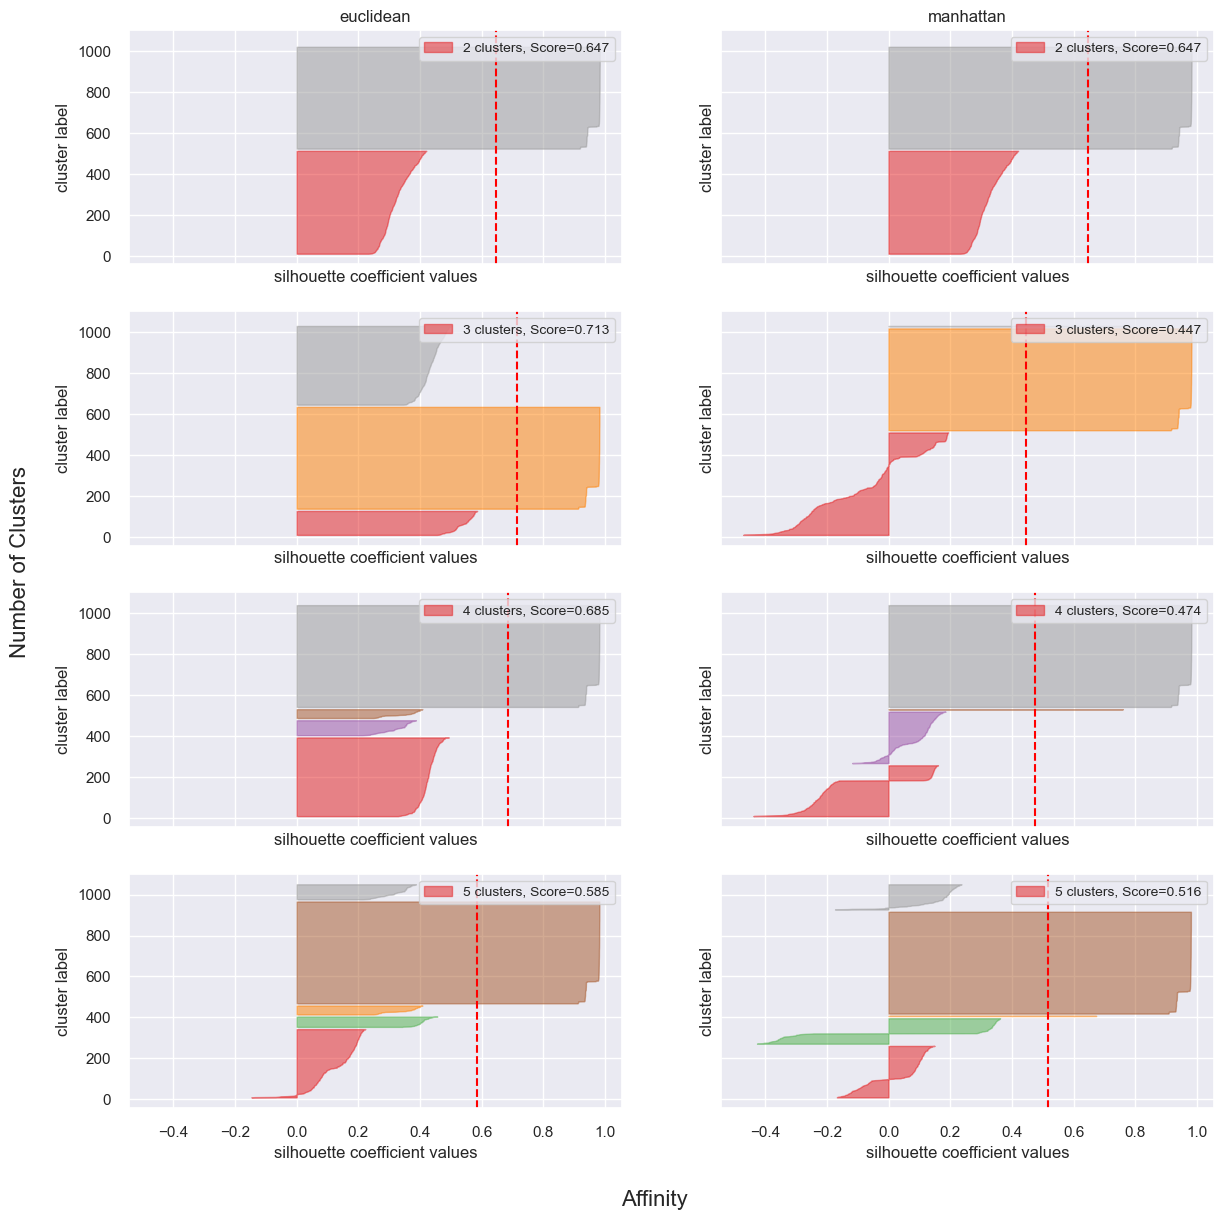

In [18]:
#initialize number of clusters as a list for looping
n_clusters = list(np.arange(2, 6))


distance_measure = ["euclidean", "manhattan"]

# save labels to 3d array for  init_method, n_cluster combinations
y_agc_pr = np.zeros((len(n_clusters), X_reduced.shape[0], 2))

fig, axs = plot.subplots(nrows=len(n_clusters), ncols=len(distance_measure), figsize=(14, 14), sharex=True, sharey=True)

# to ignore minor warnings like deprecated attributes in new_version of sklearn
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for n_idx, n in enumerate(n_clusters):
        for dist_measure_idx, metric in enumerate(distance_measure):      
            agc = AgglomerativeClustering(n_clusters=n, affinity=metric, linkage="single")
            y_agc = agc.fit_predict(X_reduced)
            y_agc_pr[n_idx, :, dist_measure_idx] = y_agc
            # Creating SilhouetteVisualizer and assigning it to an axis
            visualizer = agc_SilhouetteVisualizer(agc, ax=axs[n_idx, dist_measure_idx], is_fitted=True, legend=True)
            visualizer.fit(X_reduced)
            # Setting subplot legends via axis
            axs[n_idx, dist_measure_idx].legend([f'{n} clusters, Score={visualizer.silhouette_score_:.3f}'],
                                                loc="upper right", frameon=True, fontsize=10)
            # Setting subplot x and y labels
            axs[n_idx, dist_measure_idx].set(xlabel='silhouette coefficient values', ylabel='cluster label')

axs[0, 0].set_title("euclidean")
axs[0, 1].set_title("manhattan")

fig.text(0.5, 0.04, 'Affinity', ha='center', fontsize=16)
fig.text(0.04, 0.5, 'Number of Clusters', va='center', rotation='vertical', fontsize=16)

#### Comments
- Choice of Metrics: I used the euclidean distance metric measures the straight-line distance between two data points in Euclidean space, while the Manhattan distance metric calculates the absolute differences between the coordinates of two points.

- In this case, the silhouette analysis produced notably different results for both of the considered distance metrics, Euclidean and Manhattan. Furthermore, the Euclidean distance metric did not produce any negative silhouette coefficients, whereas the Manhattan distance metric did. 

- Since negative silhouette scores indicate difficulty in clustering and interpreting data, I concluded that Euclidean distance is the suitable distance metric to apply to this particular algorithm. Therefore, this distance metric was used to cluster the data rather than the Manhattan distance metric.

- I assume the reason for the algorithm's failure could be its sensitivity to noise in the data. During this procedure, noise could lead to sub-optimal merging decisions and ultimately compromise the clustering's effectiveness. 

- Despite the model's limitations, the number of clusters with the best score is 3. This suggests that while the algorithm may not provide a perfect clustering solution, it still has some value in helping to identify patterns within the data.

#### Visualize Agglomerative Clustering Elbow

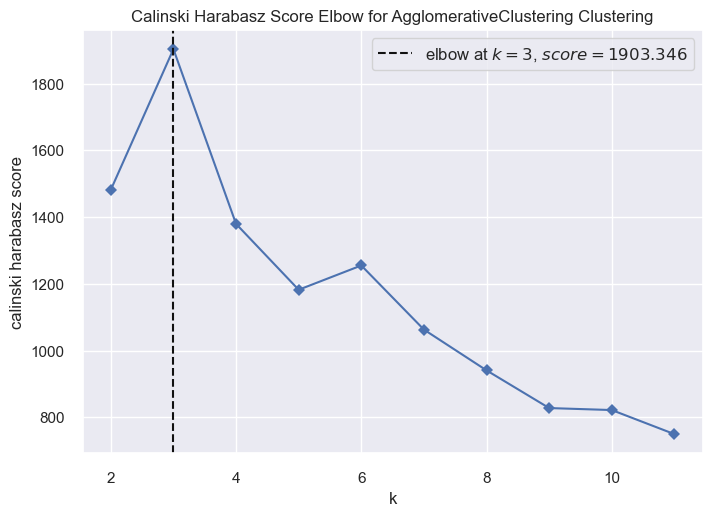

<Axes: title={'center': 'Calinski Harabasz Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [19]:
agc_model = AgglomerativeClustering(affinity="euclidean", linkage="single")
n_clusters_range = (2, 12)
visualizer = KElbowVisualizer(agc_model, k=n_clusters_range, metric='calinski_harabasz', timings=False, locate_elbow=True)
visualizer.fit(X_reduced)
visualizer.show()

#### Comments
- In order to test a wider range of values for the number of clusters (n_clusters) in the Agglomerative Clustering algorithm, I will plot the elbow or inertia curves, which display the sum of squared distance within each cluster against the number of clusters.
​
- Choice of Metric: I used Calinski-Harabasz Index as a metric for comparison. The reason for this choice is because Calinski-Harabasz Index values depend on the notion of the density and separation of clusters, it provides a reasonable standard to help identify 'good' versus 'poor' clustering methods.
​
- In this case, the silhouette analysis and elbow plot tell us that the best number of clusters to group our data into is 3, since that's the highest silhouette coefficient and Calinski-Harabasz score. 
​
- BUT, we can't just go with just that. We also need to take a look at the silhouette scores of each of the clusters individually. If some clusters have lower scores than others, it means that they might not be very distinct or meaningful. Additionally, we need to make sure that there aren't any large fluctuations in the size of our clusters. 

In [20]:
agc = AgglomerativeClustering(n_clusters=3, affinity="euclidean", linkage="single")
y_agc = agc.fit_predict(X_reduced)

#### DBSCAN -- Density-Based Clustering

- The DBSCAN algorithm is more useful because it can cluster the data without knowing how many clusters to form beforehand. This can be useful when you don't have prior knowledge or a clear idea of how many clusters you expect to find. DBSCAN also has the ability to identify outliers as noise and exclude them from clusters, rather than forcing them into a cluster like AgglomerativeClustering or other algorithms might do.

- Another advantage of DBSCAN is that it's insensitive to the shape of the clusters, meaning it can identify clusters of different shapes and sizes without much difficulty. It's also robust to clusters with different densities. Given these benefits, we'll test the DBSCAN algorithm and tune the two main parameters associated with it - min_samples and eps - to get the best results for our data.

In [21]:
# yellowbrick.cluster.silhouette
# Implements visualizers using the silhouette metric for cluster evaluation.
#
# Author:   Benjamin Bengfort
# Author:   Rebecca Bilbro
# Created:  Mon Mar 27 10:09:24 2017 -0400
#
# Copyright (C) 2017 The scikit-yb developers
# For license information, see LICENSE.txt
#
# ID: silhouette.py [57b563b] benjamin@bengfort.com $

"""
Implements visualizers that use the silhouette metric for cluster evaluation.
"""

##########################################################################
## Imports
##########################################################################

import numpy as np
import matplotlib.ticker as ticker

from sklearn.metrics import silhouette_score, silhouette_samples

from yellowbrick.utils import check_fitted
from yellowbrick.style import resolve_colors
from yellowbrick.cluster.base import ClusteringScoreVisualizer

## Packages for export

##########################################################################
## Silhouette Method for K Selection
##########################################################################


class db_SilhouetteVisualizer(ClusteringScoreVisualizer):
    """
    The Silhouette Visualizer displays the silhouette coefficient for each
    sample on a per-cluster basis, visually evaluating the density and
    separation between clusters. The score is calculated by averaging the
    silhouette coefficient for each sample, computed as the difference
    between the average intra-cluster distance and the mean nearest-cluster
    distance for each sample, normalized by the maximum value. This produces a
    score between -1 and +1, where scores near +1 indicate high separation
    and scores near -1 indicate that the samples may have been assigned to
    the wrong cluster.

    In SilhouetteVisualizer plots, clusters with higher scores have wider
    silhouettes, but clusters that are less cohesive will fall short of the
    average score across all clusters, which is plotted as a vertical dotted
    red line.

    This is particularly useful for determining cluster imbalance, or for
    selecting a value for K by comparing multiple visualizers.

    Parameters
    ----------
    estimator : a Scikit-Learn clusterer
        Should be an instance of a centroidal clustering algorithm (``KMeans``
        or ``MiniBatchKMeans``). If the estimator is not fitted, it is fit when
        the visualizer is fitted, unless otherwise specified by ``is_fitted``.

    ax : matplotlib Axes, default: None
        The axes to plot the figure on. If None is passed in the current axes
        will be used (or generated if required).

    colors : iterable or string, default: None
        A collection of colors to use for each cluster group. If there are
        fewer colors than cluster groups, colors will repeat. May also be a
        Yellowbrick or matplotlib colormap string.

    is_fitted : bool or str, default='auto'
        Specify if the wrapped estimator is already fitted. If False, the
        estimator will be fit when the visualizer is fit, otherwise, the
        estimator will not be modified. If 'auto' (default), a helper method
        will check if the estimator is fitted before fitting it again.

    kwargs : dict
        Keyword arguments that are passed to the base class and may influence
        the visualization as defined in other Visualizers.

    Attributes
    ----------
    silhouette_score_ : float
        Mean Silhouette Coefficient for all samples. Computed via scikit-learn
        `sklearn.metrics.silhouette_score`.

    silhouette_samples_ : array, shape = [n_samples]
        Silhouette Coefficient for each samples. Computed via scikit-learn
        `sklearn.metrics.silhouette_samples`.

    n_samples_ : integer
        Number of total samples in the dataset (X.shape[0])

    n_clusters_ : integer
        Number of clusters (e.g. n_clusters or k value) passed to internal
        scikit-learn model.

    y_tick_pos_ : array of shape (n_clusters,)
        The computed center positions of each cluster on the y-axis

    Examples
    --------

    >>> from yellowbrick.cluster import SilhouetteVisualizer
    >>> from sklearn.cluster import KMeans
    >>> model = db_SilhouetteVisualizer(KMeans(10))
    >>> model.fit(X)
    >>> model.show()
    """

    def __init__(self, estimator, ax=None, colors=None, is_fitted="auto", **kwargs):

        # Initialize the visualizer bases
        super(db_SilhouetteVisualizer, self).__init__(estimator, ax=ax, **kwargs)

        # Visual Properties
        # Use colors if it is given, otherwise attempt to use colormap which
        # which will override colors. If neither is found, default to None.
        # The colormap may yet still be found in resolve_colors
        self.colors = colors
        if "colormap" in kwargs:
            self.colors = kwargs["colormap"]

    def fit(self, X, y=None, **kwargs):
        """
        Fits the model and generates the silhouette visualization.
        """
        # TODO: decide to use this method or the score method to draw.
        # NOTE: Probably this would be better in score, but the standard score
        # is a little different and I'm not sure how it's used.

        if not check_fitted(self.estimator, is_fitted_by=self.is_fitted):
            # Fit the wrapped estimator
            self.estimator.fit(X, y, **kwargs)

        # Get the properties of the dataset
        self.n_samples_ = X.shape[0]
        self.n_clusters_ = np.unique(self.estimator.labels_).shape[0]

        # Compute the scores of the cluster
        labels = self.estimator.fit_predict(X)
        self.silhouette_score_ = silhouette_score(X, labels)
        self.silhouette_samples_ = silhouette_samples(X, labels)

        # Draw the silhouette figure
        self.draw(labels)

        # Return the estimator
        return self


    def draw(self, labels):
        """
        Draw the silhouettes for each sample and the average score.

        Parameters
        ----------

        labels : array-like
            An array with the cluster label for each silhouette sample,
            usually computed with ``predict()``. Labels are not stored on the
            visualizer so that the figure can be redrawn with new data.
        """

        # Track the positions of the lines being drawn
        y_lower = 10  # The bottom of the silhouette

        # Get the colors from the various properties
        color_kwargs = {"n_colors": self.n_clusters_}

        if self.colors is None:
            color_kwargs["colormap"] = "Set1"
        elif isinstance(self.colors, str):
            color_kwargs["colormap"] = self.colors
        else:
            color_kwargs["colors"] = self.colors

        colors = resolve_colors(**color_kwargs)

        # For each cluster, plot the silhouette scores
        self.y_tick_pos_ = []
        
        
        for idx in range(-1, self.n_clusters_):

            # Collect silhouette scores for samples in the current cluster
            values = self.silhouette_samples_[labels == idx]
            values.sort()

            # Compute the size of the cluster and find upper limit
            size = values.shape[0]
            y_upper = y_lower + size

            color = colors[idx]
            self.ax.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                values,
                facecolor=color,
                edgecolor=color,
                alpha=0.5,
            )

            # Collect the tick position for each cluster
            self.y_tick_pos_.append(y_lower + 0.5 * size)

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10

        # The vertical line for average silhouette score of all the values
        self.ax.axvline(
            x=self.silhouette_score_,
            color="red",
            linestyle="--",
            label="Average Silhouette Score",
        )

        return self.ax


    def finalize(self):
        """
        Prepare the figure for rendering by setting the title and adjusting
        the limits on the axes, adding labels and a legend.
        """

        # Set the title
        self.set_title(
            ("Silhouette Plot of {} Clustering for {} Samples in {} Centers").format(
                self.name, self.n_samples_, self.n_clusters_
            )
        )

        # Set the X and Y limits
        # The silhouette coefficient can range from -1, 1;
        # but here we scale the plot according to our visualizations

        # l_xlim and u_xlim are lower and upper limits of the x-axis,
        # set according to our calculated max and min score with necessary padding
        l_xlim = max(-1, min(-0.1, round(min(self.silhouette_samples_) - 0.1, 1)))
        u_xlim = min(1, round(max(self.silhouette_samples_) + 0.1, 1))
        self.ax.set_xlim([l_xlim, u_xlim])

        # The (n_clusters_+1)*10 is for inserting blank space between
        # silhouette plots of individual clusters, to demarcate them clearly.
        self.ax.set_ylim([0, self.n_samples_ + (self.n_clusters_ + 1) * 10])

        # Set the x and y labels
        self.ax.set_xlabel("silhouette coefficient values")
        self.ax.set_ylabel("cluster label")

        # Set the ticks on the axis object.
        self.ax.set_yticks(self.y_tick_pos_)
        self.ax.set_yticklabels(str(idx) for idx in range(self.n_clusters_))
        # Set the ticks at multiples of 0.1
        self.ax.xaxis.set_major_locator(ticker.MultipleLocator(0.1))

        # Show legend (Average Silhouette Score axis)
        self.ax.legend(loc="best")



Text(0.04, 0.5, 'Minimum number of samples')

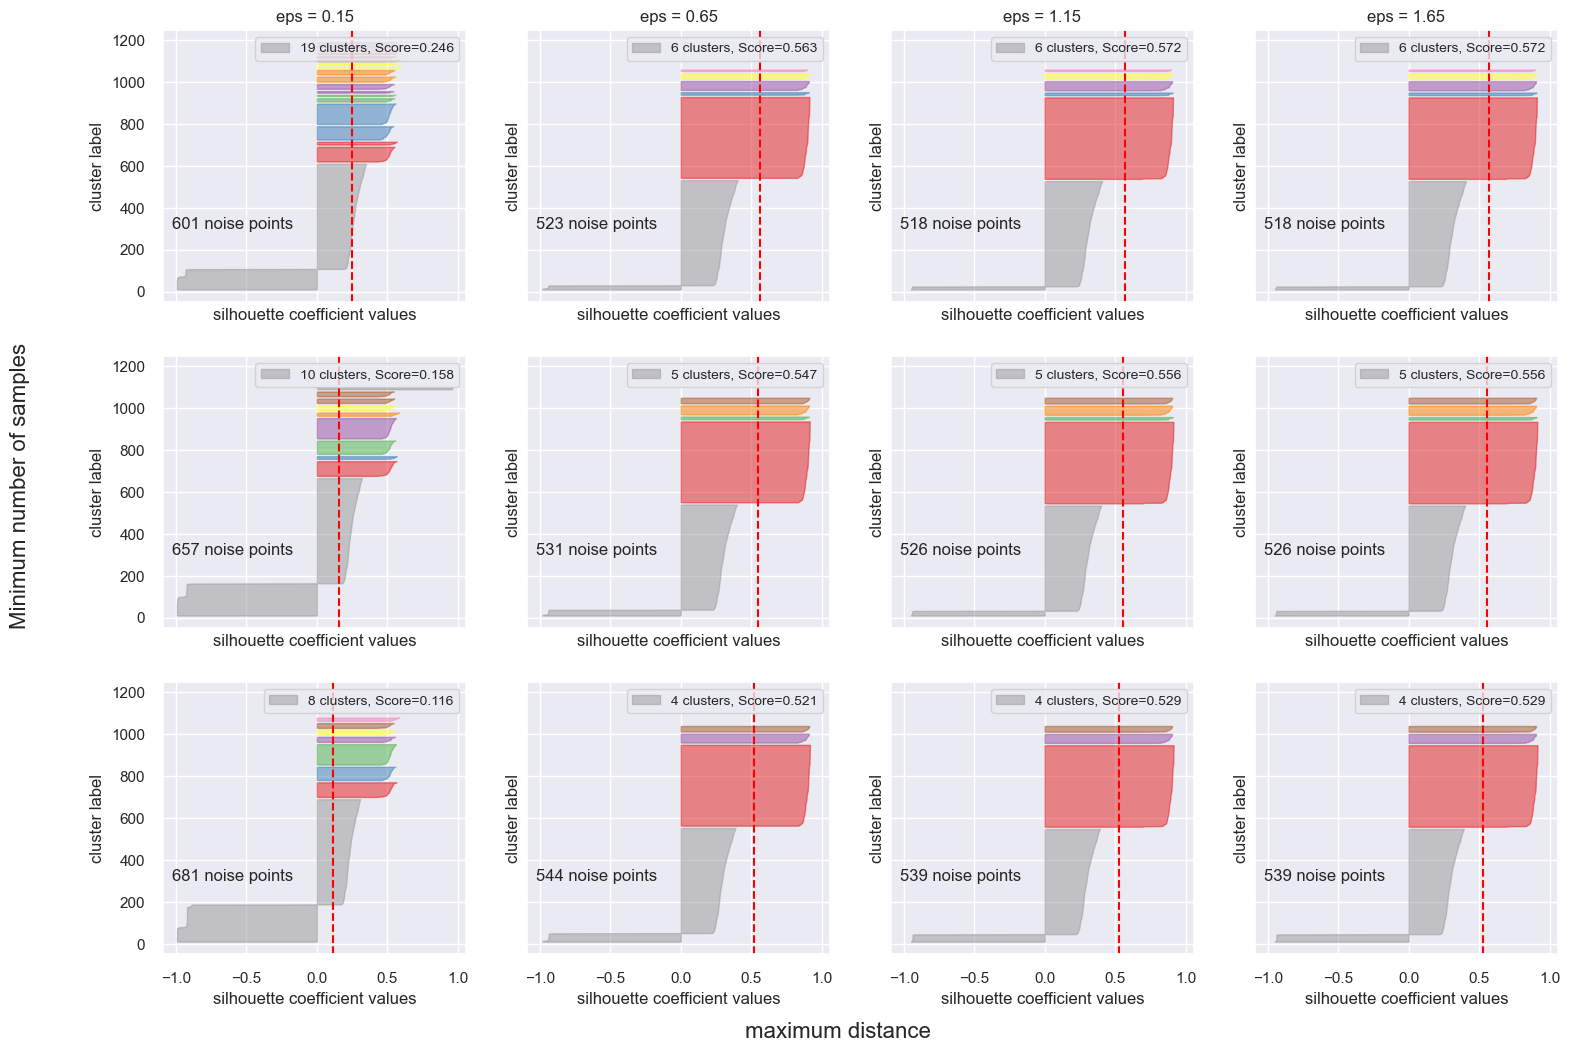

In [22]:
# list for range minimum sample size to be considered in hyperparameter tuning
min_samples = list(np.arange(5, 20, 5))

eps = list(np.arange(0.15, 2.0, 0.5))

y_db_pr = np.zeros((len(min_samples), X_reduced.shape[0], len(eps)))

fig, axs = plot.subplots(nrows=len(min_samples), ncols=len(eps), figsize=(18, 12), sharex=True, sharey=True)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for i, n in enumerate(min_samples):
        for j, max_dist in enumerate(eps):
            db = DBSCAN(eps=max_dist, min_samples=n)
            y_db = db.fit_predict(X_reduced)
            y_db_pr[i, :, j] = y_agc
            n_noise_ = len(db.labels_[db.labels_ == -1])
            # Creating SilhouetteVisualizer and assigning it to an axis
            visualizer = db_SilhouetteVisualizer(db, ax=axs[i, j], is_fitted=True, legend=True)
            visualizer.fit(X_reduced)
            # Setting subplot legends via axis
            axs[i, j].legend([f'{visualizer.n_clusters_} clusters, Score={visualizer.silhouette_score_:.3f}'],
                                                loc="upper right", frameon=True, fontsize=10)
            # Setting subplot x and y labels
            axs[i, j].set(xlabel='silhouette coefficient values', ylabel='cluster label')
            # setting estimated number of noise points
            
            axs[i, j].text(-0.6, 300, '{} noise points'.format(n_noise_), ha='center', wrap=True)            
            
for i in range(len(eps)):
    axs[0, i].set_title("eps = {}".format(eps[i]))

fig.text(0.5, 0.04, 'maximum distance', ha='center', fontsize=16)
fig.text(0.04, 0.5, 'Minimum number of samples', va='center', rotation='vertical', fontsize=16)


#### Comments

- So, after testing DBSCAN algorithm, I realized that it's not performing as well as I'd hoped. In particular, the highest score I observed in the silhouette plots was only 0.572, which is lower than the scores produced by the K-Means and AgglomerativeClustering algorithms, which scored 0.713.

- Furthermore, I saw that DBSCAN was classifying more than half of the data as noise points for all combinations of the hyperparameters min_samples and eps. This is surprising, given that DBSCAN is generally considered more flexible and robust than other clustering algorithms like AgglomerativeClustering or K-Means.

- The reason for this poor performance may be related to the distance measure used in DBSCAN. By default, DBSCAN uses the Euclidean distance, which can become less effective in high-dimensional data due to the curse of dimensionality. Finding an appropriate value for eps, which influences the DBSCAN algorithm's performance, can become more and more difficult as the dimensionality of the data increases.

- This means that even though the other algorithms we've tested may also be affected by the curse of dimensionality, its effects are more pronounced in DBSCAN. Overall, our results suggest that DBSCAN may not be the best choice for this particular data set.

Text(0.5, 0, '$Snapshots$ $Sorted$ $By$ $Distance$')

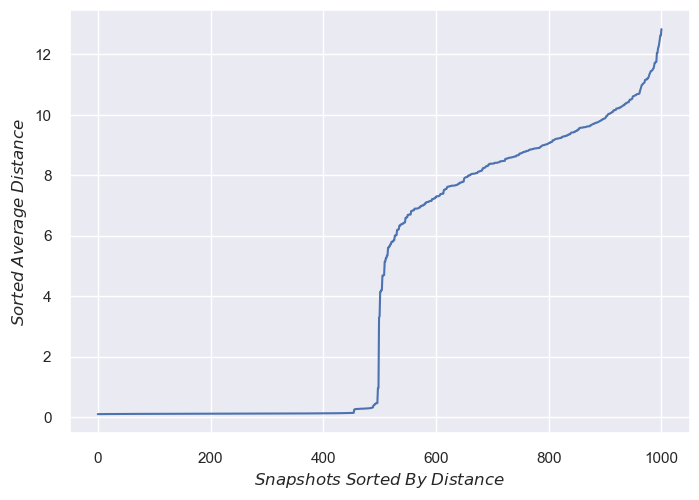

In [23]:
#### Import NearestNeighbors from Scikit-learn to calculate the average distance between each point and its n_neighbors
from sklearn.neighbors import NearestNeighbors

# obtained avarage distance between each point in the dataset and its 300 nearest neighbors.
min_samples = 300 
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(X_reduced)

# obtain average distances
distances, indices = neighbors_fit.kneighbors(X_reduced)

# Sort distance values by ascending value and plot
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plot.plot(distances)

plot.ylabel('$Sorted$ $Average$ $Distance$')
plot.xlabel('$Snapshots$ $Sorted$ $By$ $Distance$')

- From the plot above, it is evident that there is no distinct elbow for the sorted distances.

- In order to locate the point of maximum curvature, an algorithm has been implemented which involves computing the ratio of the second derivative to the square of the first derivative. This algorithm is used to approximate the point of maximum curvature.

Text(0.5, 0, '$Snapshots$ $Sorted$ $By$ $Distance$')

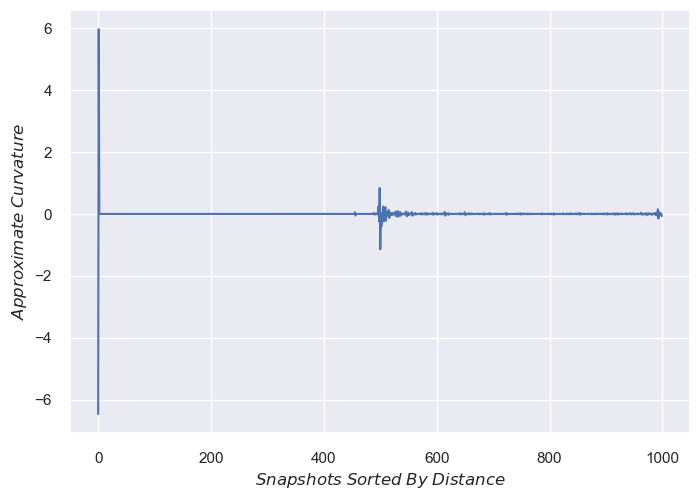

In [24]:
curve = []
for i in range(0, 1001):
    curve.append(1/(1+(distances[i-2] - distances[i-1])**2)**1.5)
    
curvature = []

for i in range(0, 1000):
    curvature.append((distances[i-2] + distances[i] - 2*distances[i-1])/2 * curve[i-1])

plot.plot(curvature)
plot.ylabel('$Approximate$ $Curvature$')
plot.xlabel('$Snapshots$ $Sorted$ $By$ $Distance$')

- The maximum value of this curve is equivalent to the optimal value for $eps$.

In [25]:
eps = np.max(curvature)

print("Optimal value for $eps$ is {}".format(eps))

Optimal value for $eps$ is 5.970810438441256


- Again, I will now loop through combinations of min_samples and eps values slightly above (min_samples = 350, eps = 8) and below (min_samples = 250, eps = 4) the values estimated here to find the model of best fit.

Text(0.04, 0.5, 'Minimum number of samples')

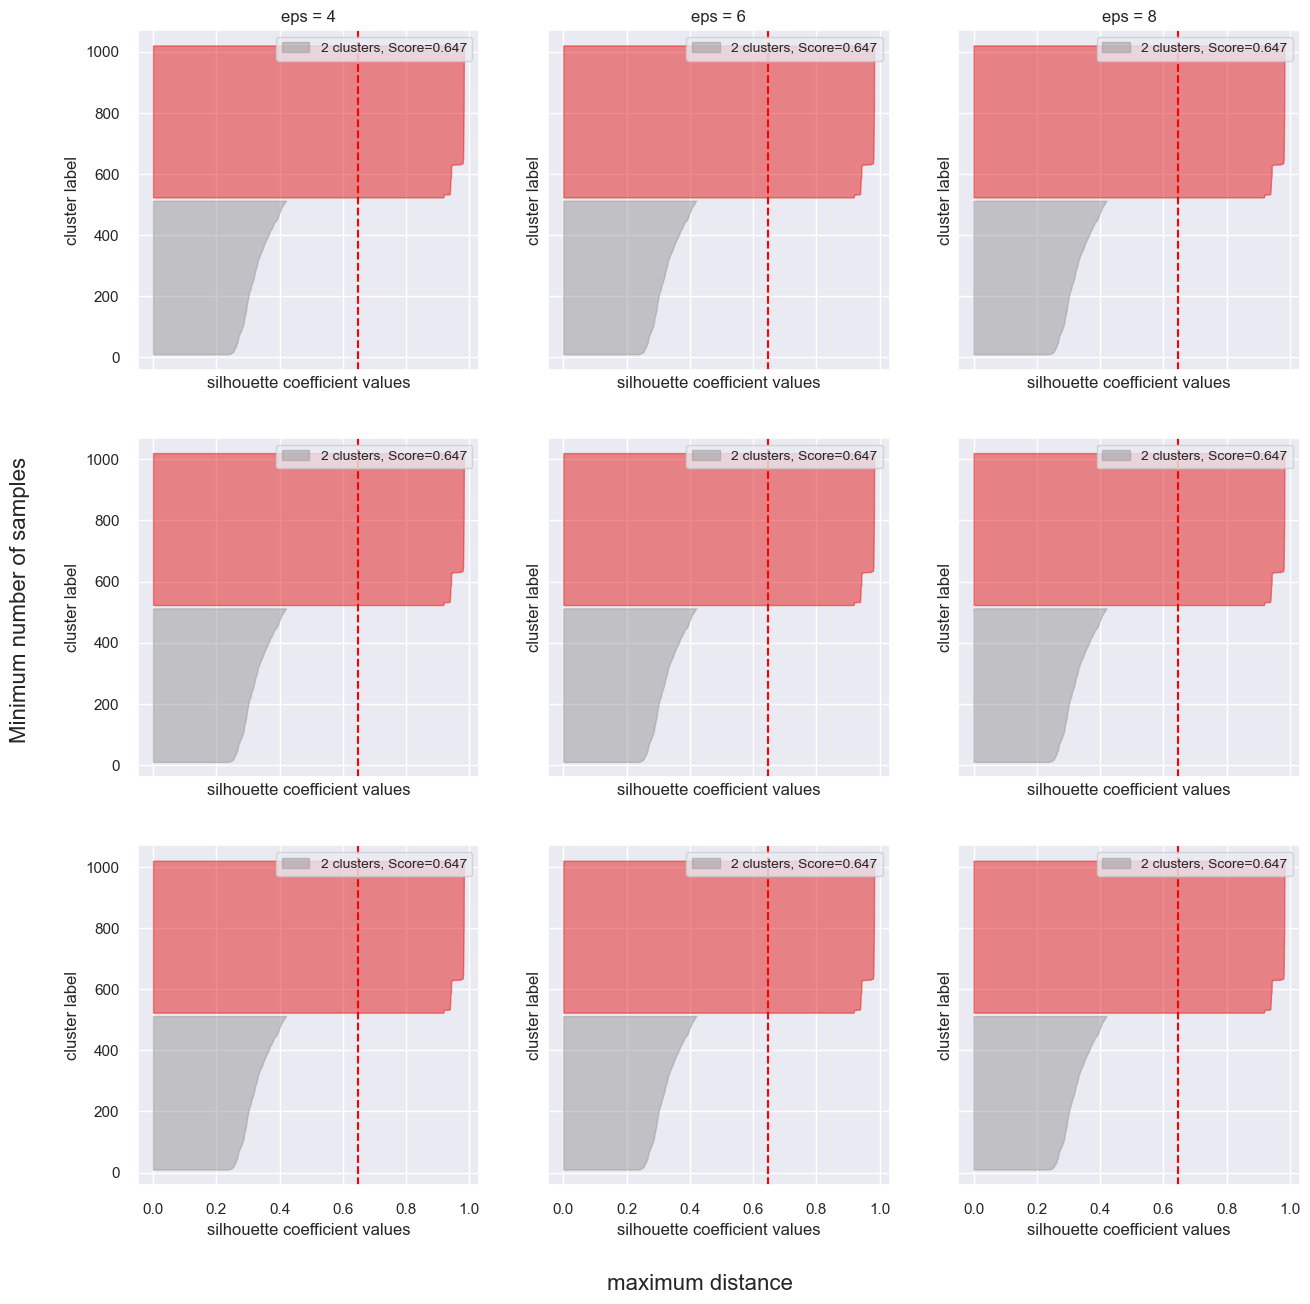

In [26]:
# list for range minimum sample size to be considered in hyperparameter tuning
min_samples = list(np.arange(250, 400, 50))

# list for range of 
eps = list(np.arange(4, 10, 2))

y_db_pr = np.zeros((len(min_samples), X_reduced.shape[0], len(eps)))

fig, axs = plot.subplots(nrows=len(min_samples), ncols=len(eps), figsize=(15, 15), sharex=True, sharey=True)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for i, n in enumerate(min_samples):
        for j, max_dist in enumerate(eps):
            db = DBSCAN(eps=max_dist, min_samples=n)
            y_db = db.fit_predict(X_reduced)
            y_db_pr[i, :, j] = y_agc
            # Creating SilhouetteVisualizer and assigning it to an axis
            visualizer = db_SilhouetteVisualizer(db, ax=axs[i, j], is_fitted=True, legend=True)
            visualizer.fit(X_reduced)
            # Setting subplot legends via axis
            axs[i, j].legend([f'{visualizer.n_clusters_} clusters, Score={visualizer.silhouette_score_:.3f}'],
                                                loc="upper right", frameon=True, fontsize=10)
            # Setting subplot x and y labels
            axs[i, j].set(xlabel='silhouette coefficient values', ylabel='cluster label')

for i in range(len(eps)):
    axs[0, i].set_title("eps = {}".format(eps[i]))

fig.text(0.5, 0.04, 'maximum distance', ha='center', fontsize=16)
fig.text(0.04, 0.5, 'Minimum number of samples', va='center', rotation='vertical', fontsize=16)

### Comments
From the silhouette analysis performed on the Density Based Clustering algorithm, the following conclusions can be drawn:

- The silhouette coefficients do not significantly change for values of min_samples and eps slightly above (min_samples = 350, eps = 8) or below (min_samples = 250, eps = 4).

- This indicates that the hyperparameter tuning technique used to determine the optimal values of min_samples and eps has produced an accurate fit. Therefore, the trained model has min_samples set to 300 and eps set to 6.19.
- There is a noteworthy similarity between the clustering results and average silhouette coefficients (0.647) obtained for DBSCAN with the hyperparameters specified above, and those obtained for both K-Means and AgglomerativeClustering with n_clusters = 2.

- It is interesting to note that the initial combination of hyperparameters considered for DBSCAN did not yield such results, which validates the efficacy of the hyperparameter tuning technique employed here.
- However, it is important to mention that although the tuning technique resulted in a better fit with min_samples = 300 and eps = 6.19, approximately half of the samples are assigned to the cluster with below average silhouette score.

In [27]:
db = DBSCAN(eps=6.19, min_samples=300)
y_db = db.fit_predict(X_reduced)

## Model Comparison

In [28]:
kmeans = KMeans(n_clusters=3, init="k-means++")
y_kmeans = kmeans.fit_predict(X_reduced)

agc = AgglomerativeClustering(n_clusters=3, affinity="euclidean", linkage="single")
y_agc = agc.fit_predict(X_reduced)

db = DBSCAN(eps=6.19, min_samples=300)
y_db = db.fit_predict(X_reduced)

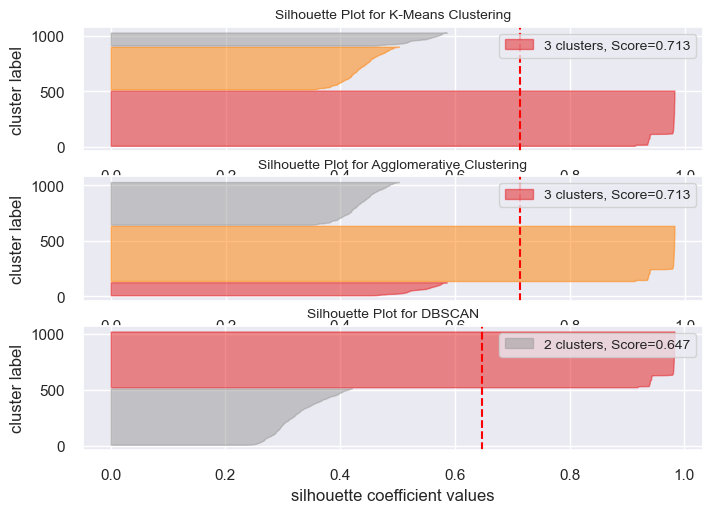

In [29]:
fig, axs = plot.subplots(nrows=3, ncols=1)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    # Creating SilhouetteVisualizer for K-means
    visualizer = SilhouetteVisualizer(kmeans, ax=axs[0], is_fitted=True, legend=True)
    visualizer.fit(X_reduced)
    # Setting subplot legends via axis
    axs[0].legend([f'{visualizer.n_clusters_} clusters, Score={visualizer.silhouette_score_:.3f}'],
                                                loc="upper right", frameon=True, fontsize=10)
    # Setting subplot x and y labels
    axs[0].set(xlabel='silhouette coefficient values', ylabel='cluster label')
    axs[0].set_title("Silhouette Plot for K-Means Clustering", fontsize=10)

    # Creating SilhouetteVisualizer for Agglomerative Clustering
    visualizer = agc_SilhouetteVisualizer(agc, ax=axs[1], is_fitted=True, legend=True)
    visualizer.fit(X_reduced)
    axs[1].legend([f'{visualizer.n_clusters_} clusters, Score={visualizer.silhouette_score_:.3f}'],
                                                loc="upper right", frameon=True, fontsize=10)
    # Setting subplot x and y labels
    axs[1].set(xlabel='silhouette coefficient values', ylabel='cluster label')
    axs[1].set_title("Silhouette Plot for Agglomerative Clustering", fontsize=10)

    # Creating SilhouetteVisualizer for DBSCAN
    visualizer = db_SilhouetteVisualizer(db, ax=axs[2], is_fitted=True, legend=True)
    visualizer.fit(X_reduced)
    axs[2].legend([f'{visualizer.n_clusters_} clusters, Score={visualizer.silhouette_score_:.3f}'],
                                                loc="upper right", frameon=True, fontsize=10)
    # Setting subplot x and y labels
    axs[2].set(xlabel='silhouette coefficient values', ylabel='cluster label')
    axs[2].set_title("Silhouette Plot for DBSCAN", fontsize=10)

#### Comments
- Initially, we believed that K-Means and AgglomerativeClustering algorithms outperform DBSCAN when considering the average silhouette coefficient. This coefficient measures the degree of similarity amongst the data points in each cluster compared to the other clusters, with higher values indicating better clustering.

- However, solely focusing on the average silhouette coefficient to evaluate the clustering efficacy may not be sufficient, as the thickness of the silhouette plots for K-Means and AgglomerativeClustering can fluctuate greatly when predicting a certain number of clusters. Therefore, we need to analyze the performance of these algorithms using other metrics.

- In this particular case, since the true labels are known, additional metrics can be used to compare the results of each algorithm with the true labels. The Adjusted Rand Index (ARI) measures the similarity between the labels of the produced clusters by an algorithm and the true labels. The higher the ARI score, the better the clustering. A perfect clustering would have an ARI score of 1.0.

- The Adjusted Mutual Information (AMI) is another metric similar to ARI, but it ignores permutations. Again, a higher score indicates a better clustering, and a perfect clustering would have a score of 1.0.

- Additionally, Homogeneity and Completeness metrics can be employed. Homogeneity checks if each cluster contains only members of a single class while Completeness ensures that all members of a particular class are assigned to the same cluster. The scores for both metrics are between 0.0 and 1.0, with 1.0 representing a perfect score. The V-measure is the harmonic mean of Homogeneity and Completeness.

- In summary, to make a comprehensive assessment of the performance of each algorithm for clustering the data, it is imperative to consider these metrics alongside the average silhouette coefficient.

In [30]:
metrics_on_data = pd.DataFrame(columns=["ARI", "AMI", "Homogeneity", "Completeness", "Silhouette"], 
                                   index=["K-Means", "Agglomerative Clustering", "DBSCAN"],
                                   dtype=float)


metrics_on_data.loc["K-Means", "ARI"] = metrics.adjusted_rand_score(y_kmeans, flag)
metrics_on_data.loc["K-Means", "AMI"] = metrics.adjusted_mutual_info_score(y_kmeans, flag)
metrics_on_data.loc["K-Means", "Homogeneity"] = metrics.homogeneity_score(y_kmeans, flag)
metrics_on_data.loc["K-Means", "Completeness"] = metrics.completeness_score(y_kmeans, flag)
metrics_on_data.loc["K-Means", "Silhouette"] = metrics.silhouette_score(X_reduced, y_kmeans, metric='euclidean')

metrics_on_data.loc["Agglomerative Clustering", "ARI"] = metrics.adjusted_rand_score(y_agc, flag)
metrics_on_data.loc["Agglomerative Clustering", "AMI"] = metrics.adjusted_mutual_info_score(y_agc, flag)
metrics_on_data.loc["Agglomerative Clustering", "Homogeneity"] = metrics.homogeneity_score(y_agc, flag)
metrics_on_data.loc["Agglomerative Clustering", "Completeness"] = metrics.completeness_score(y_agc, flag)
metrics_on_data.loc["Agglomerative Clustering", "Silhouette"] = metrics.silhouette_score(X_reduced, y_agc, metric='euclidean')

metrics_on_data.loc["DBSCAN", "ARI"] = metrics.adjusted_rand_score(y_db, flag)
metrics_on_data.loc["DBSCAN", "AMI"] = metrics.adjusted_mutual_info_score(y_db, flag)
metrics_on_data.loc["DBSCAN", "Homogeneity"] = metrics.homogeneity_score(y_db, flag)
metrics_on_data.loc["DBSCAN", "Completeness"] = metrics.completeness_score(y_db, flag)
metrics_on_data.loc["DBSCAN", "Silhouette"] = metrics.silhouette_score(X_reduced, y_db, metric='euclidean')

### Metric Heatmap

<Axes: >

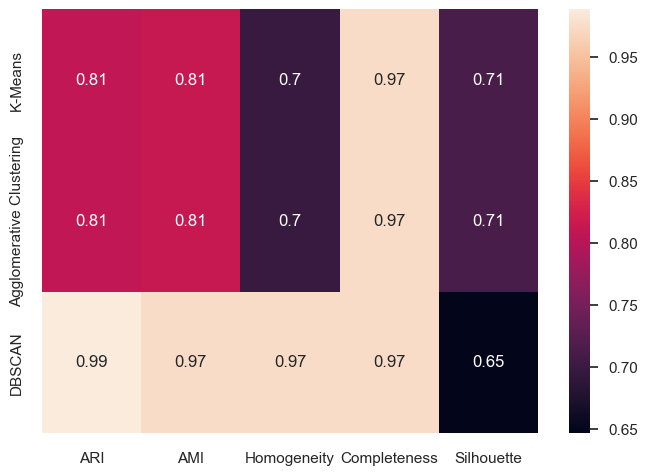

In [31]:
sns.heatmap(data=metrics_on_data, annot=True)

#### Comments
- So there's this heatmap above that shows how different clustering algorithms performed based on specific metrics we talked about earlier: ARI, AMI, Homogeneity, Completeness, and Silhouette Score.

- It looks like DBSCAN did really well and got almost a perfect score for ARI, AMI, Homogeneity, and Completeness, but it had the lowest Silhouette Score. Despite that, DBSCAN's clustering predictions were still the most similar and accurate when compared to the actual labels. Basically, it did a great job of keeping each cluster pure while also making sure that each member was assigned to the right one.

- So, based on all of that, the best clustering model for this problem is DBSCAN with min_samples = 300 and eps = 6.19, which gives us n_clusters = 2. 

- But, it's worth mentioning that K-Means and Agglomerative Clustering algorithms could also produce similar results if trained with n_clusters = 2.

#### Save Results From Optimal Model

In [32]:
db = DBSCAN(eps=6.19, min_samples=300)
y_db = db.fit_predict(X_reduced)
question_one = pd.DataFrame(columns=["labels_predicted"], index=list(np.arange(0,X_reduced.shape[0])), dtype=float)
question_one["labels_predicted"] = y_db
question_one.to_csv("results.csv")